# Megan's MNIST CNN
### Modified from https://nextjournal.com/gkoehler/pytorch-mnist

In [96]:
import torch
import torchvision

In [97]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [98]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [99]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [100]:
example_data.shape
#So one test data batch is a tensor of shape: ([1000,1,28,28])
#This means we have 1000 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one).

torch.Size([1000, 1, 28, 28])

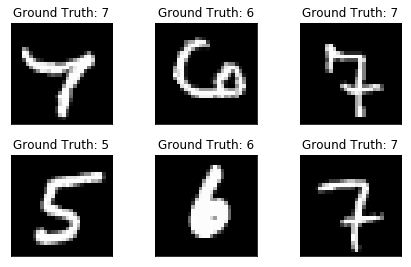

In [66]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


The ground truth is what you measured for your target variable for the training and testing examples. Nearly all the time you can safely treat this the same as the label. https://datascience.stackexchange.com/questions/17839/what-is-ground-truth

In [67]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [68]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x)) #Fully Connected Layer/Activation
        x = F.dropout(x, training=self.training)
        x = self.fc2(x) #Fully Connected Layer/Activation
        return F.log_softmax(x, dim=1) #Softmax gets probabilities. 

In [69]:
#Initalize the network & optimzer
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [70]:
#create two lists for saving training and testing losses
#On the x-axis we want to display the number of training examples the network has seen during training
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [71]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #torch.save(network.state_dict(), '/results/model.pth')
            #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [72]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [73]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\pli6894\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3136, Accuracy: 1261/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.336449
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.251104
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.249510
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.187000
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.174551
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.050505
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.889992
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.706823
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.423215
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.258499
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.017797
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.988839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.741536
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.813868
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.704005
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.744148
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.757163
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.610055
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.663117
Train Epoch: 1 [12160

Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.078244
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.120031
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.295543
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.060964
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.148758
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.202124
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.067676
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.190951
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.146423
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.197967
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.135667
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.192287
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.049419
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.150001
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.063606
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.066461
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.294848
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.075917
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.048916
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.091816


In [74]:
import numpy as np
print(np.asarray(test_losses).shape)
print(np.asarray(test_counter).shape)

(4,)
(4,)


In [75]:
print(np.asarray(test_losses))

[2.31359084 0.11179089 0.06832112 0.05617993]


In [76]:
print(np.asarray(test_counter))

[     0  60000 120000 180000]


Text(0,0.5,'Loss')

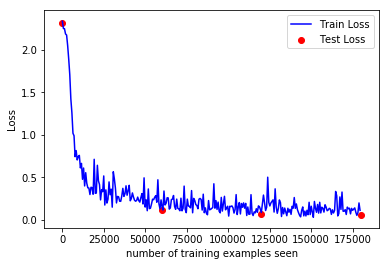

In [104]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Loss')

In [80]:
with torch.no_grad():
    output = network(example_data)

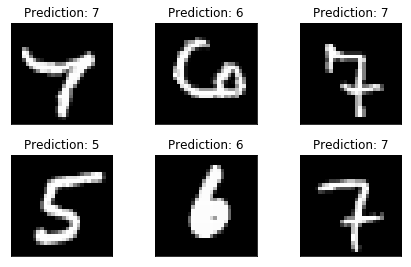

In [81]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

In [82]:
# how do I look at where Prediction = 5 (for example) specifically?
# how do I clear the learned weights without having to EXIT & come back into the notebook?

# Visualization
Reference: https://github.com/arundasan91/IS7033/blob/master/CNN_invariance/.ipynb_checkpoints/Rotational%20Invariance%20in%20Convolutional%20Neural%20Networks-checkpoint.ipynb

In [83]:
def custom_viz(kernels, path=None, cols=None):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: TODO: Number of columns (doesn't work completely yet.)
    
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]

    Tot = N*C

    # If single channel kernel with HxW size,
    # plot them in a row.
    # Else, plot image with C number of columns.
    if C>1:
        columns = C
    elif cols==None:
        columns = N
    elif cols:
        columns = cols
    rows = Tot // columns 
    rows += Tot % columns

    pos = range(1,Tot + 1)

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(rows,columns,pos[k])
            ax.imshow(img, cmap='gray')
            plt.axis('off')
            k = k+1

    set_size(30,30,ax)
    if path:
        plt.savefig(path, dpi=100)
    
    plt.show()

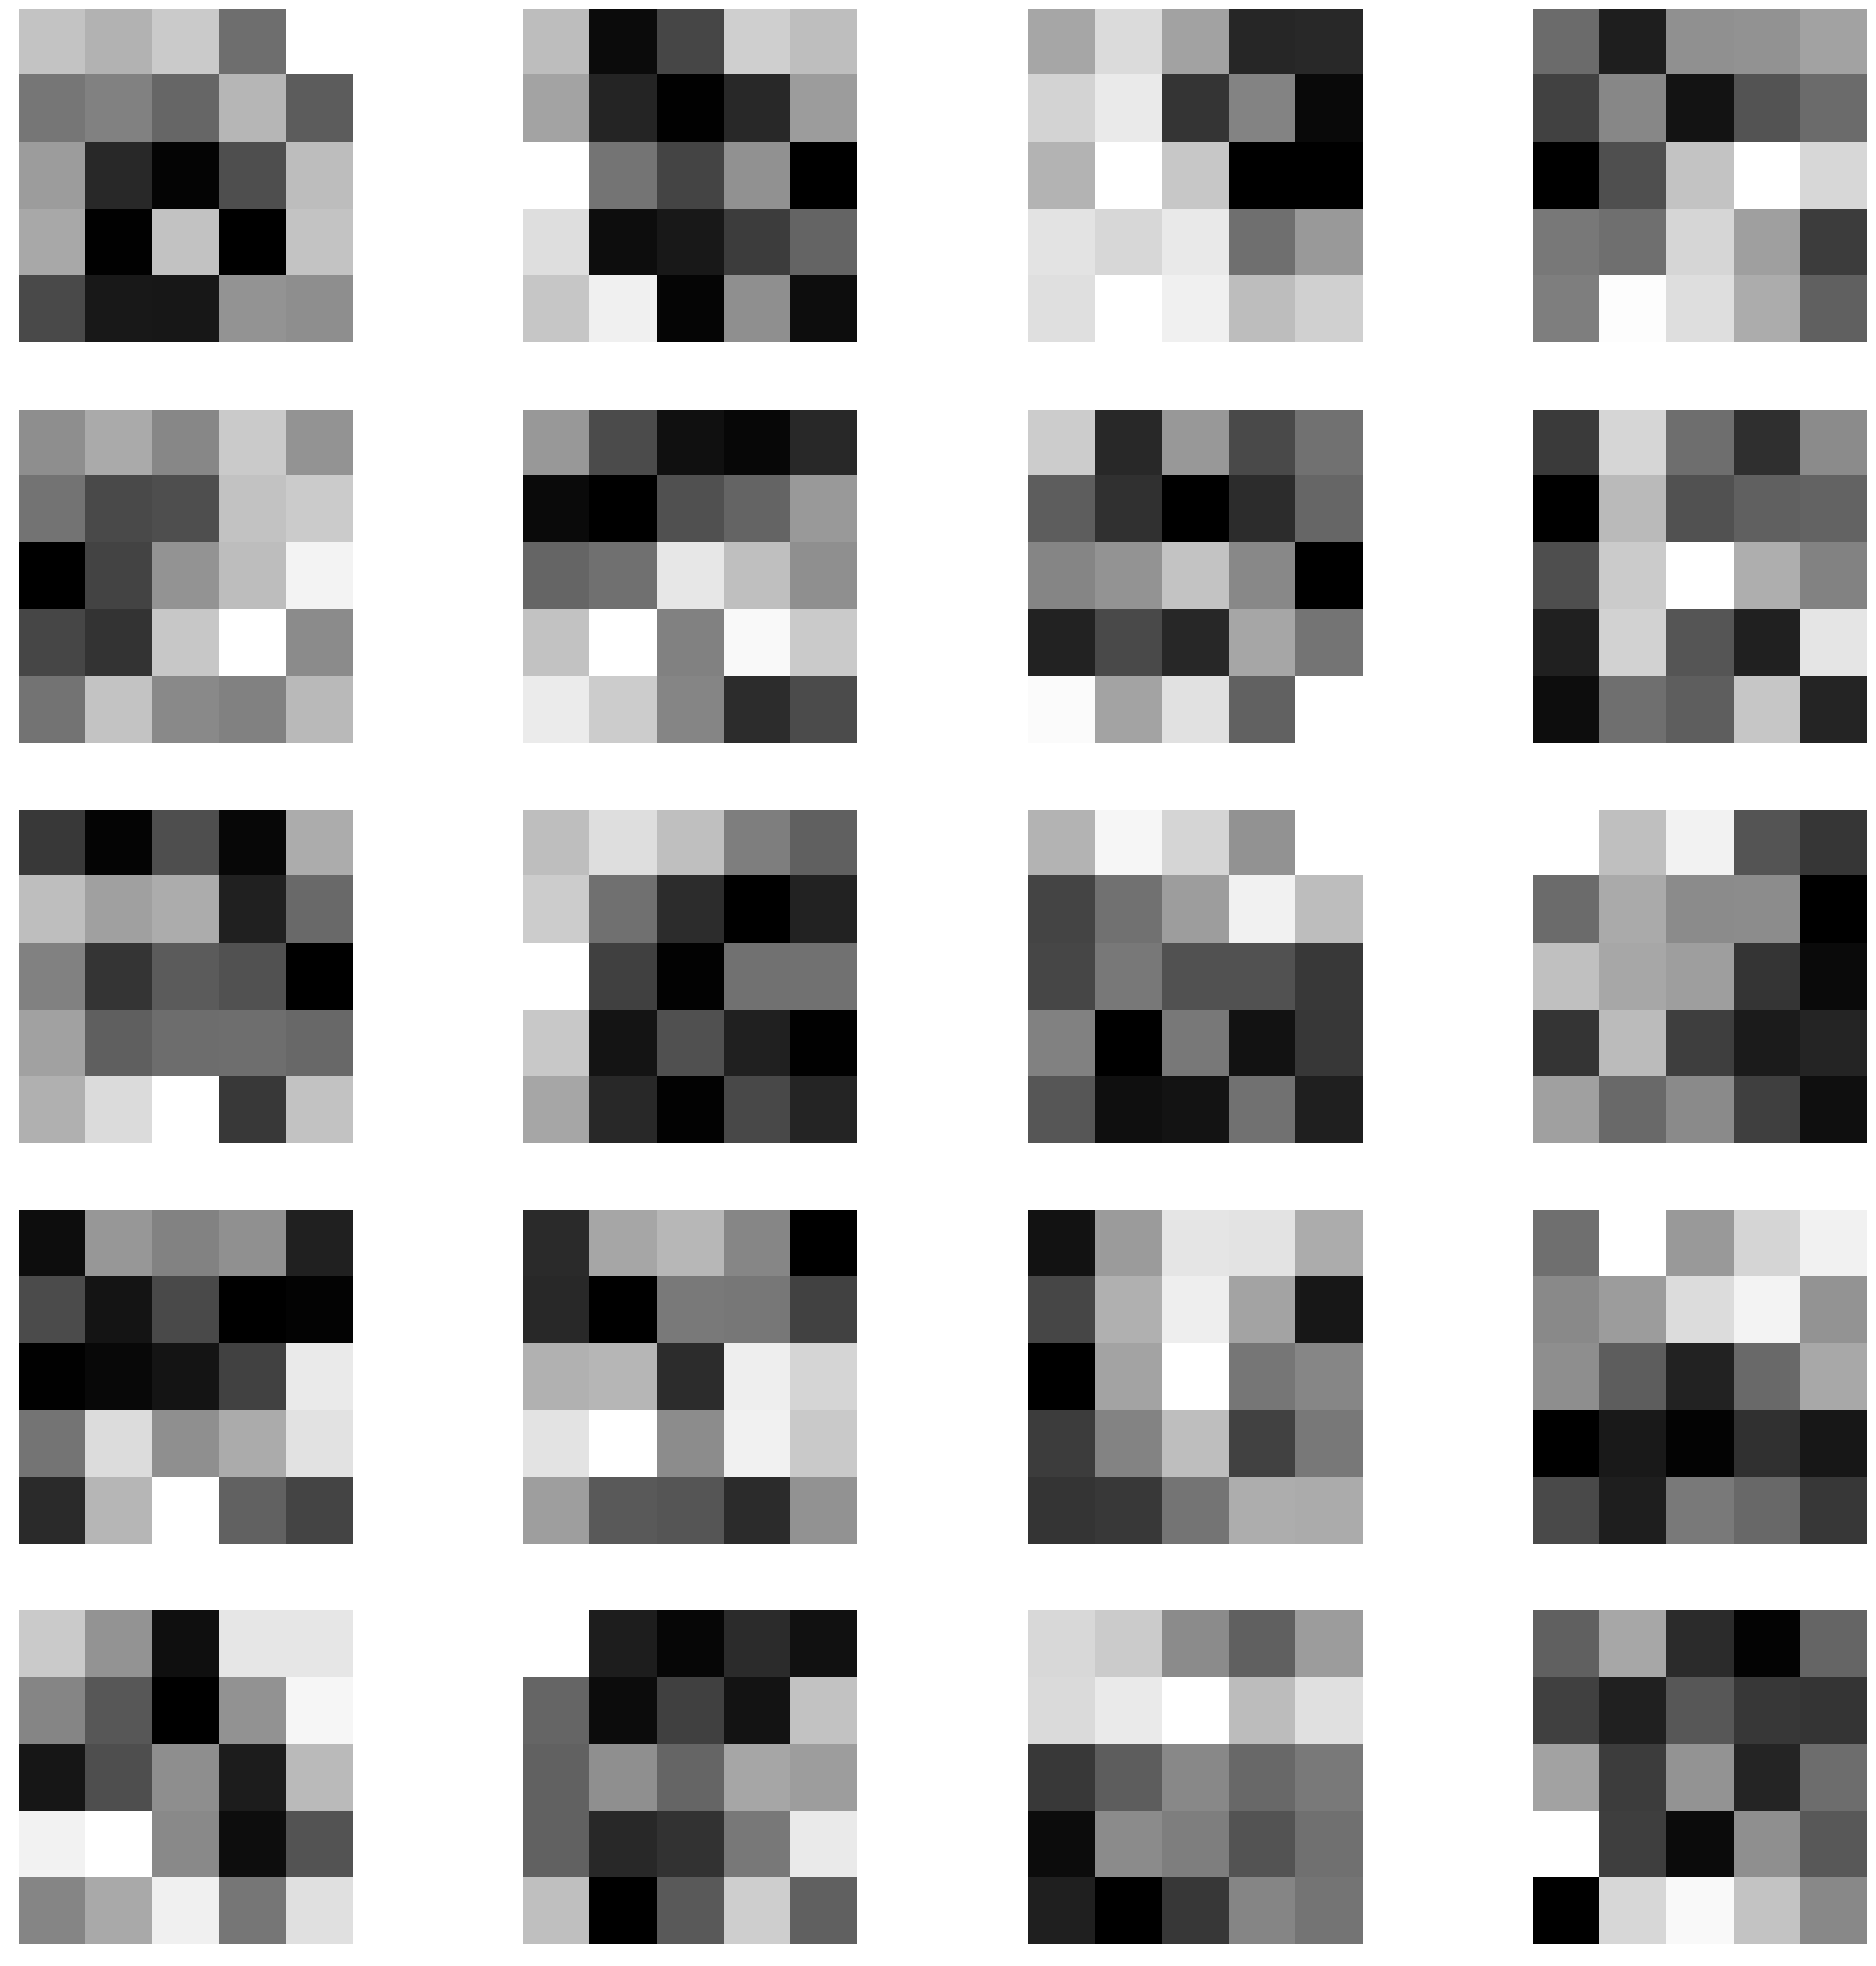

In [87]:
kernels = network.conv1.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, None, 4)

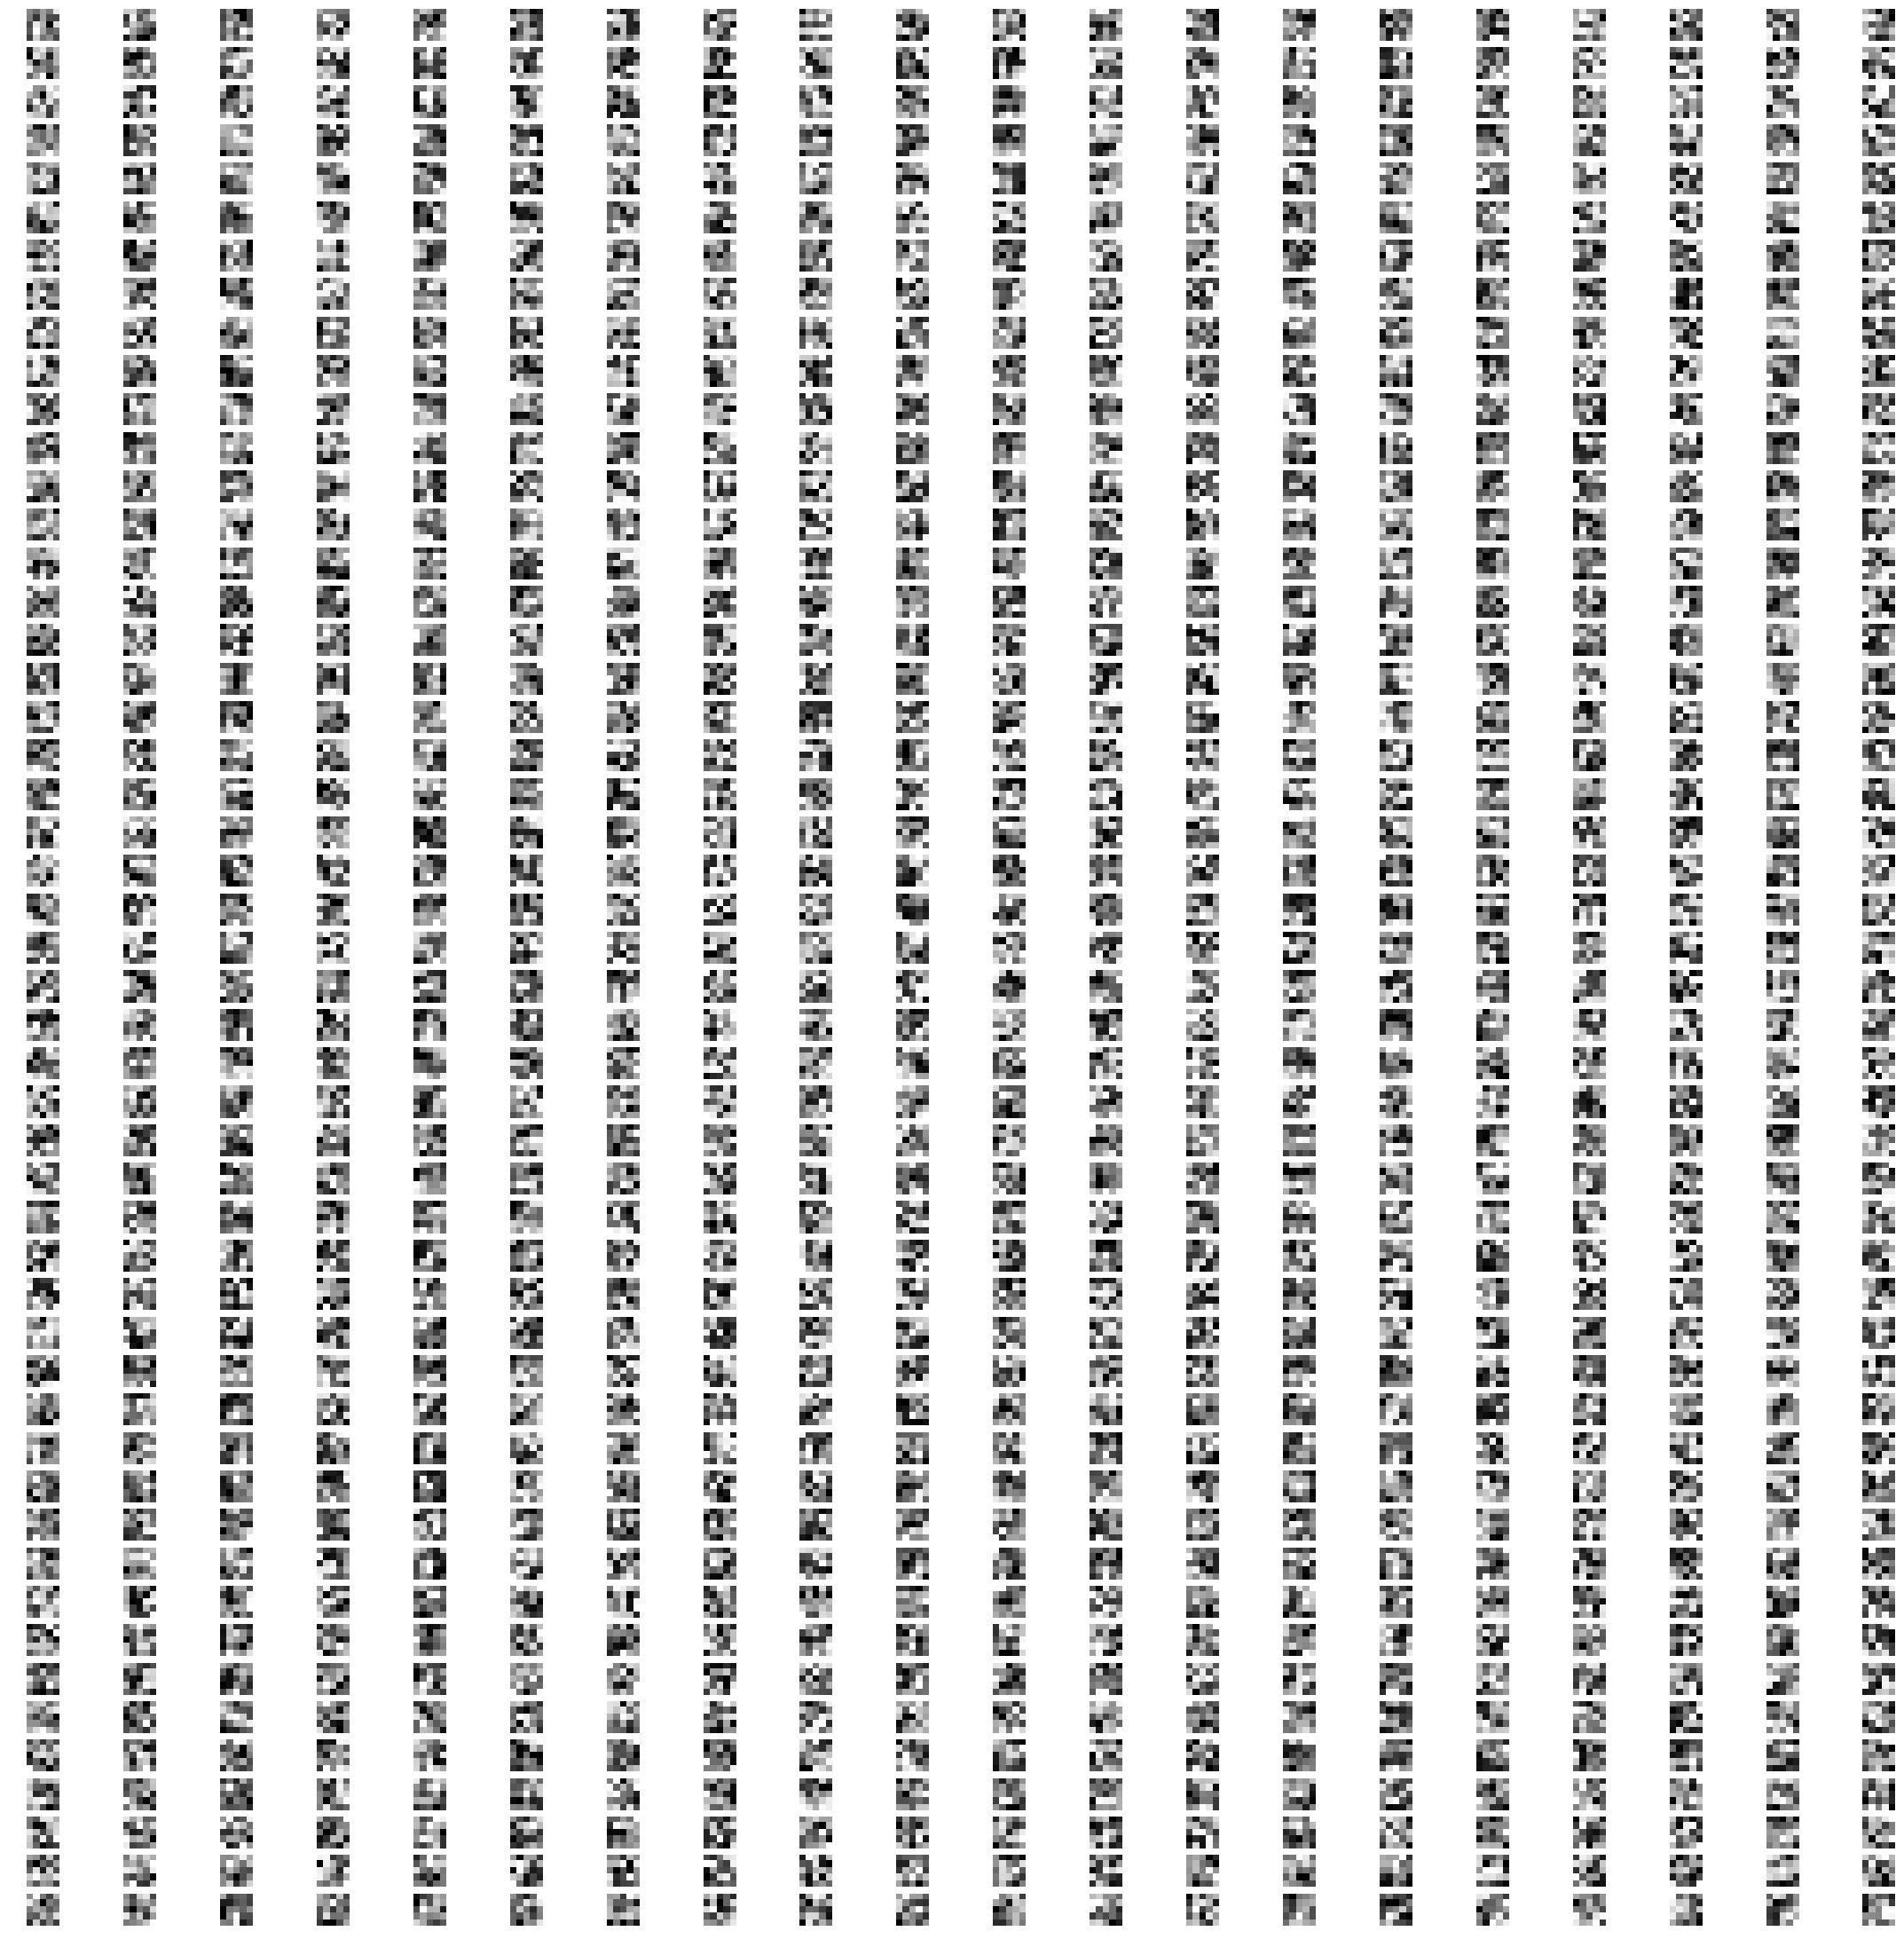

In [90]:
kernels = network.conv2.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, None, cols=5)

In [103]:
from torchsummary import summary
summary(network, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
         Dropout2d-3             [-1, 50, 8, 8]               0
            Linear-4                  [-1, 500]         400,500
            Linear-5                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 1.64
Estimated Total Size (MB): 1.79
----------------------------------------------------------------
